In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

import cv2
from PIL import Image, ImageDraw

In [2]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

--2021-09-02 22:08:49--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: 'imagenet_classes.txt.1'

     0K ..........                                            100%  683K=0.01s

2021-09-02 22:08:49 (683 KB/s) - 'imagenet_classes.txt.1' saved [10472/10472]



In [3]:
model = torchvision.models.wide_resnet50_2(pretrained=True, progress=False)
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

preprocess4viz = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224)
]) 

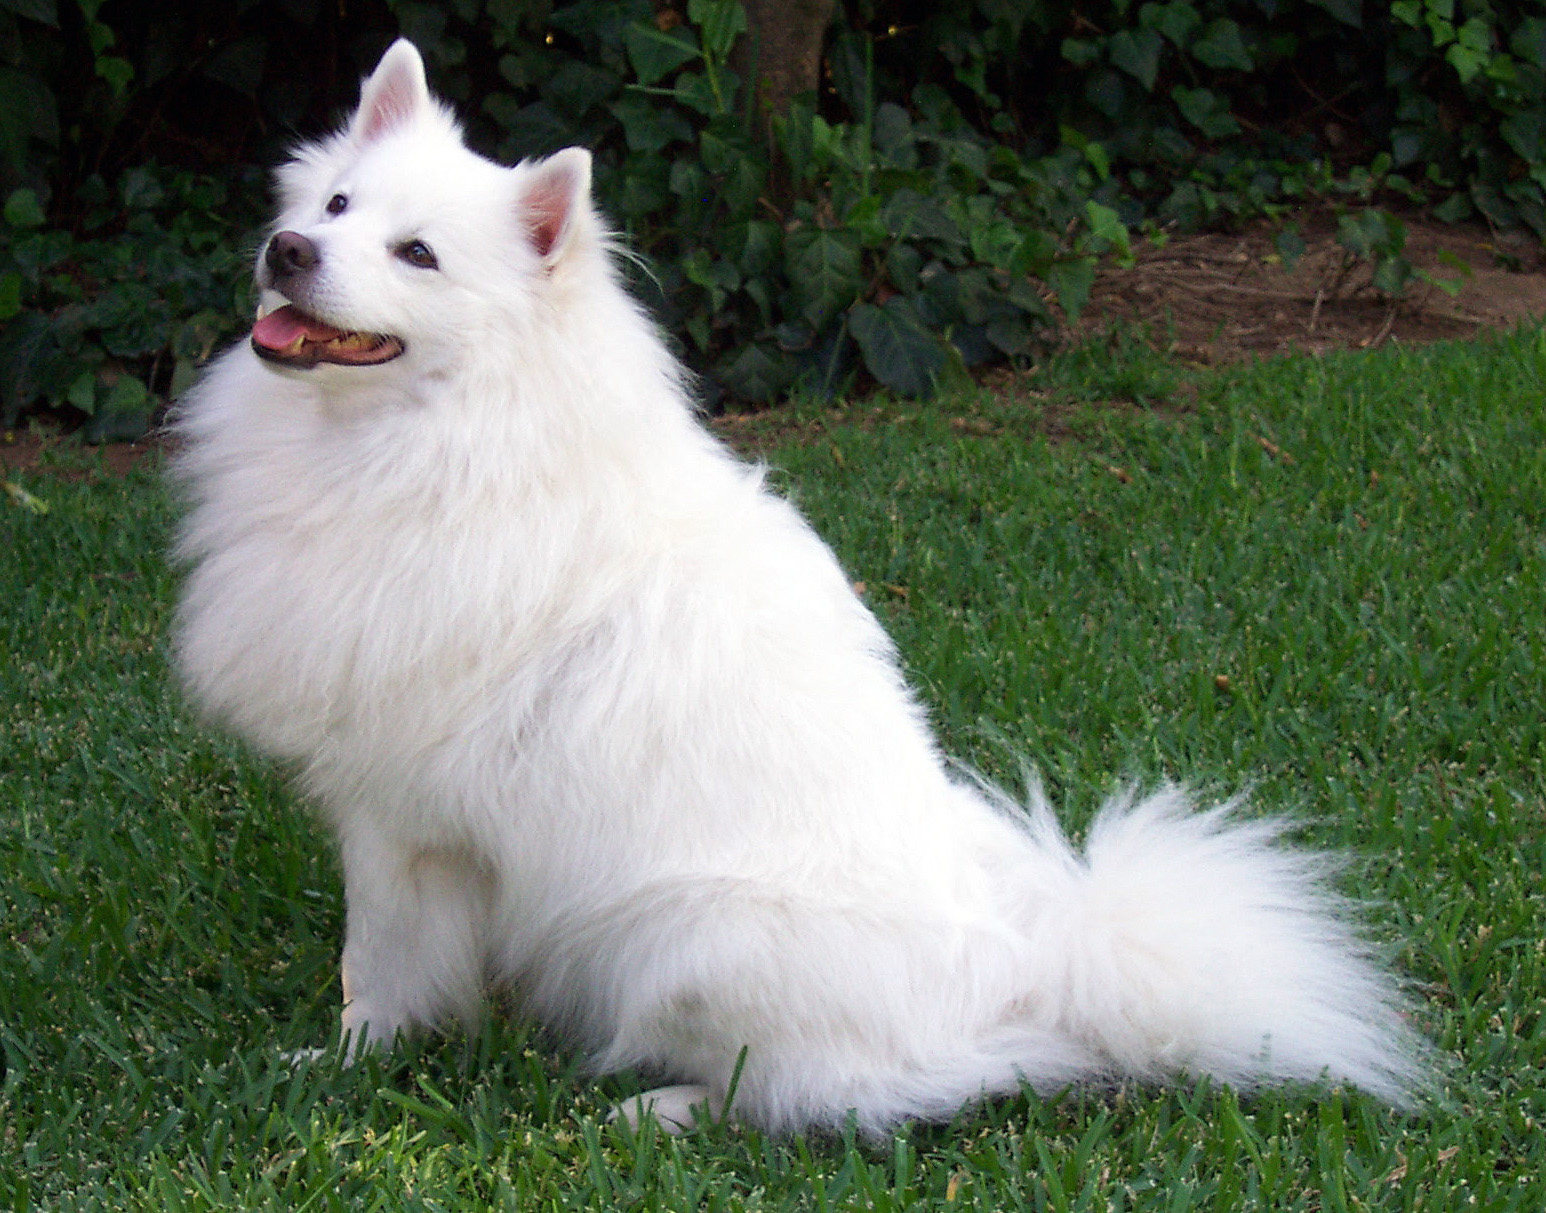

In [62]:
filename = r'C:\Users\Hyogun\Laboratory\DATASETS\ImageNet_samples\dog.jpg'
input_image = Image.open(filename)
input_image

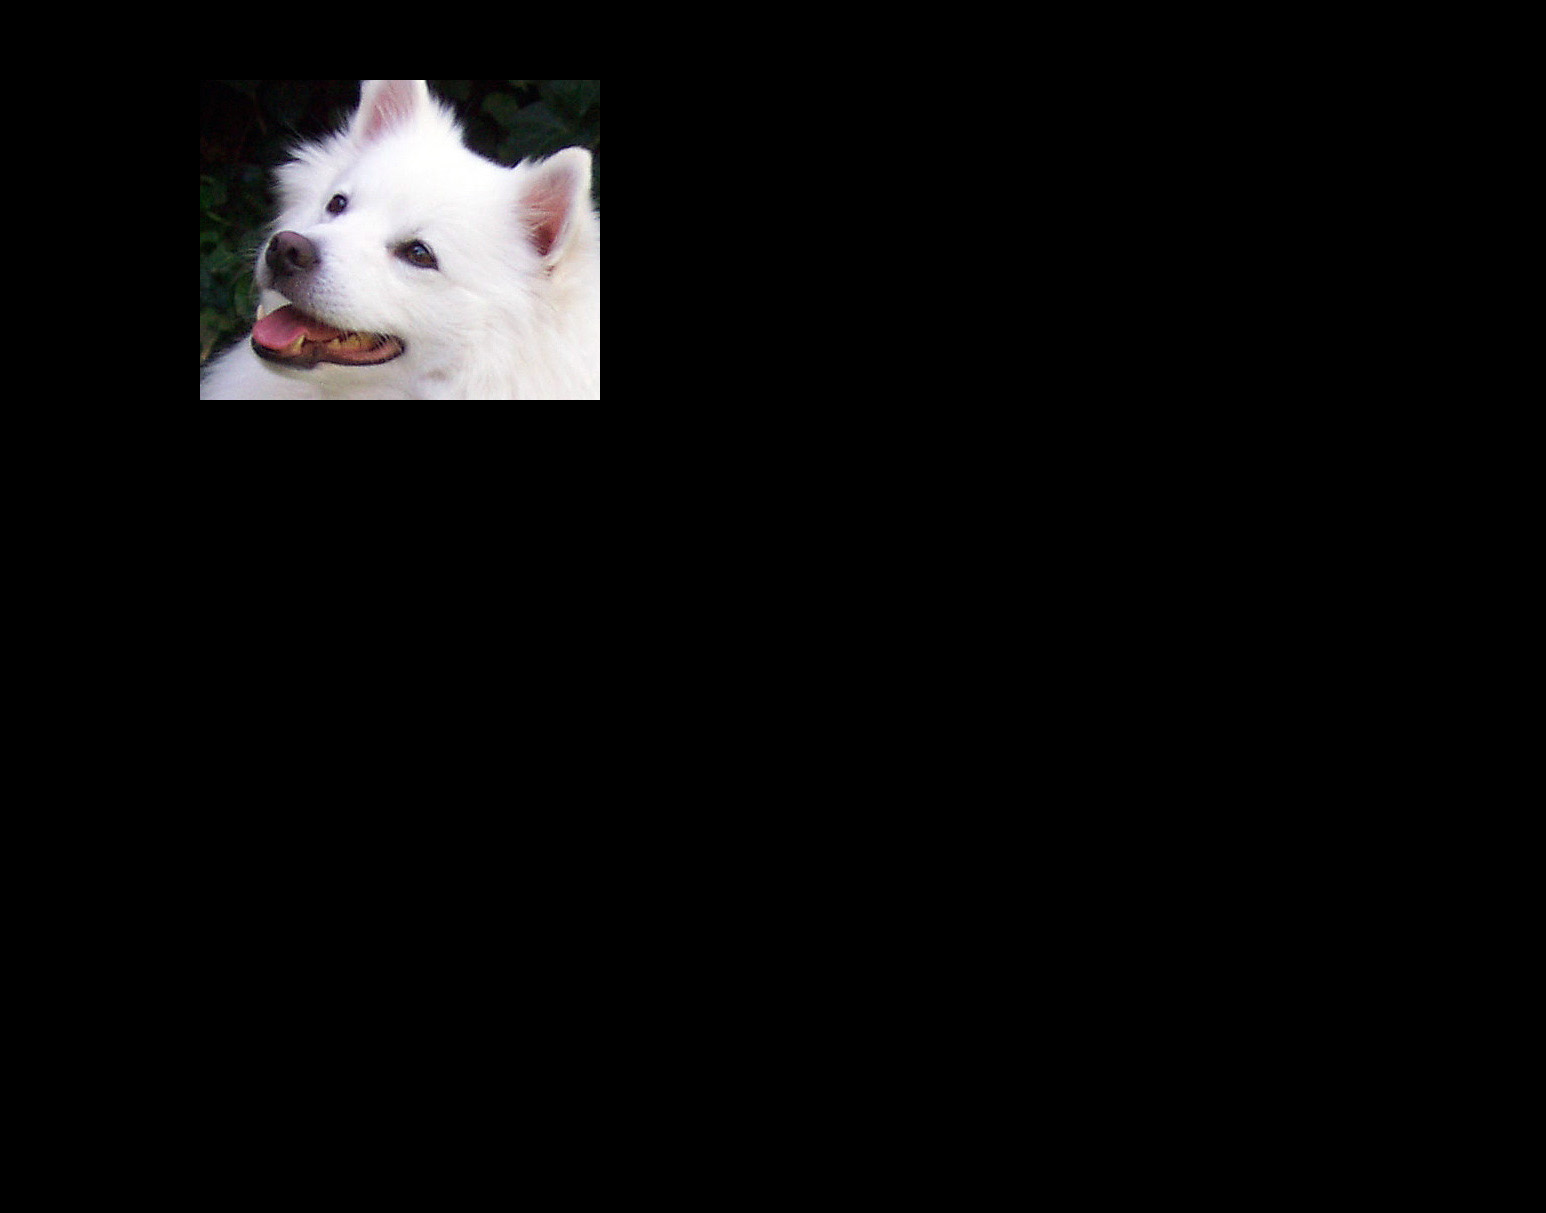

In [83]:
def do_nothing():
    return input_image.copy() 

def box():
    im = input_image.copy() 
    draw = ImageDraw.Draw(im)
    draw.rectangle([200, 80, 600, 400], fill=0)
    draw.rectangle([200, 600, 800, 1100], fill=0)
    return im

def crop():
    im = np.array(input_image.copy())
    mask = np.zeros_like(im)
    mask[80:400, 200:600] = 1
    im *= mask
    return im

# im = do_nothing()
# im = box() 
im = Image.fromarray(crop())
im

In [ ]:
input_image = im

In [66]:
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

In [75]:
with torch.no_grad():
    output = model(input_batch)
probabilities = torch.nn.functional.softmax(output[0], dim=0)

k = 5
topk_prob, topk_catid = torch.topk(probabilities, k)
for i in range(k):
    index = topk_catid[i]
    category = categories[index]
    prob = topk_prob[i].item()
    print(f'{index:>3d} {category:20s} {prob:>10%}') 

258 Samoyed              23.266113%
259 Pomeranian           20.466389%
203 West Highland white terrier 20.341958%
283 Persian cat           6.778636%
270 white wolf            3.469505%


In [76]:
# CAM
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.layer4.register_forward_hook(get_activation('layer4'))
with torch.no_grad():
    output = model(input_batch)
output.shape

torch.Size([1, 1000])

In [77]:
def normalize(x):
    x -= x.min()
    x /= x.max()
    return x

def cam_to_blend(cam, alpha=.5):
    cam = normalize(cam)
    cam = cv2.resize(cam, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    cam_cmap = plt.cm.jet(cam)[:,:,:3]  # RGBA -> RGB
    cam_cmap = 255. * normalize(cam_cmap)
    cam_cmap = cam_cmap.astype(np.uint8) 
    cam_cmap = Image.fromarray(cam_cmap)
    cropped = preprocess4viz(input_image)  # PIL
    return Image.blend(cropped, cam_cmap, alpha)

In [78]:
i = 2
class_index = topk_catid[i]
category = categories[class_index]
prob = topk_prob[i].item()
print(f'{class_index:>3d} {category:20s} {prob:%}') 

203 West Highland white terrier 20.341958%


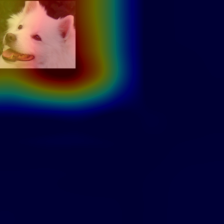

In [79]:
cam = model.fc.weight[class_index][:, None, None] * activation['layer4'][0] 
cam = abs(cam.sum(dim=0)) 
cam = cam.detach().cpu().numpy()
cam_to_blend(cam, alpha=.4)

In [80]:
# GRAD-CAM
def get_grad(name):
    def hook(model, grad_input, grad_output):
        grad[name] = grad_output
    return hook

for layer_name in ['layer1', 'layer2', 'layer3', 'layer4']:
    model.__getattr__(layer_name).register_forward_hook(get_activation(layer_name))
    model.__getattr__(layer_name).register_full_backward_hook(get_grad(layer_name))

grad = {}
model.zero_grad(set_to_none=True)
output = model(input_batch) 
output[0, class_index].backward()

In [81]:
def get_grad_cam(layer_name):
    grad_cam = torch.mean(grad[layer_name][0], dim=[2, 3])[:, :, None, None] * activation[layer_name]
    grad_cam = abs(grad_cam.sum(dim=[0, 1]))   # 28x28
    grad_cam = grad_cam.detach().cpu().numpy()
    return grad_cam

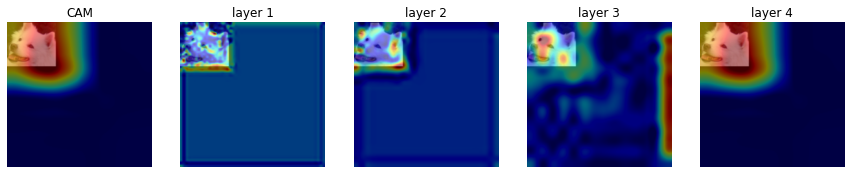

In [82]:
plt.figure(figsize=(15, 3))
plt.subplot(151)
plt.title('CAM')
plt.imshow(np.array(cam_to_blend(cam)))
plt.axis('off')
for i in range(1, 5):
    plt.subplot(151+i)
    plt.title(f'layer {i}')
    plt.imshow(np.array(cam_to_blend(get_grad_cam(f'layer{i}')))) 
    plt.axis('off')
plt.show() 